# Init 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from os import path, listdir
from IPython.display import Video

from utils import *
from pre_processing import *
from change_detection import *
from object_classification import *
from post_processing import *
from run_all_videos import *

warnings.filterwarnings('ignore') 

# Load Video

In [2]:
video_path = path.join('data', 'videos', 'cut videos', 'not_alarm2.mp4')
colored_vid = load_video(video_path=video_path, gray_scale=False)
Video(video_path, height=400, width=600)

# Preprocessing

## Histograms Calculation

### Preprocessed images outline

In [3]:
approved_objects_info = []

In [4]:
images_path = path.join('data', 'object_outline')
image_list = load_images(images_path)

### Calculating the outline histograms

In [5]:
window_size = 15
histograms_mean_dict = generate_histograms_mean_dict(image_list, window_size)

### Clustering the hitograms mean and calculating the mean for each cluster

In [6]:
bins = 2
allowed_histogram_means = calculate_allowed_histograms_means(histograms_mean_dict, bins)

## Object Size calculation

### Creating a grid of the input image

In [7]:
images_path = path.join('data', 'preprocessing_images')
image_to_grid = load_images(images_path)[0] # taking the first image based on the knowledge all images sizes are the same

In [8]:
grid_size = 5 # grid the image with boxes of 5X5
image_x_grid = np.arange(0, image_to_grid.shape[1], grid_size)
image_y_grid = np.arange(0, image_to_grid.shape[0], grid_size)

### Creating a database for approved object size information

In [9]:
first_object_location = [600, 400, 300, 150]
object_size_info = get_grids(image_x_grid, image_y_grid, first_object_location)

In [10]:
approved_objects_info.append({"RED": allowed_histogram_means["RED"],
                             "GREEN": allowed_histogram_means["GREEN"],
                             "BLUE": allowed_histogram_means["BLUE"],
                             "location": [object_size_info]})

# Change Detection 

## Set Parameters 

In [11]:
univariate = True
cut_percent = 100
predict = True
k=3
t=0.7
alpha=2.5
learning_rate=0.5
k_warm_up=1
model_path = path.join('data', 'models', f'{univariate}-{cut_percent}.pickle')

colored_vid = resize(colored_vid, percent=cut_percent, gray_scale=False)

if univariate:
    full_vid = load_video(video_path=video_path, gray_scale=True)
    vid = resize(full_vid, percent=cut_percent, gray_scale=True)
else:
    vid = colored_vid.copy()

## GMM

### Create Foreground Mask 

In [12]:
v_fg_mask = change_detection(vid, k=k, t=t, alpha=alpha, learning_rate=learning_rate, 
                             k_warm_up=k_warm_up, univariate=univariate, model_path=model_path, predict=predict)

  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

GMM Model loaded from a file
Start iterating over frames to detect foreground


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:56<00:00,  5.54s/it]


GMM Model saved to a file


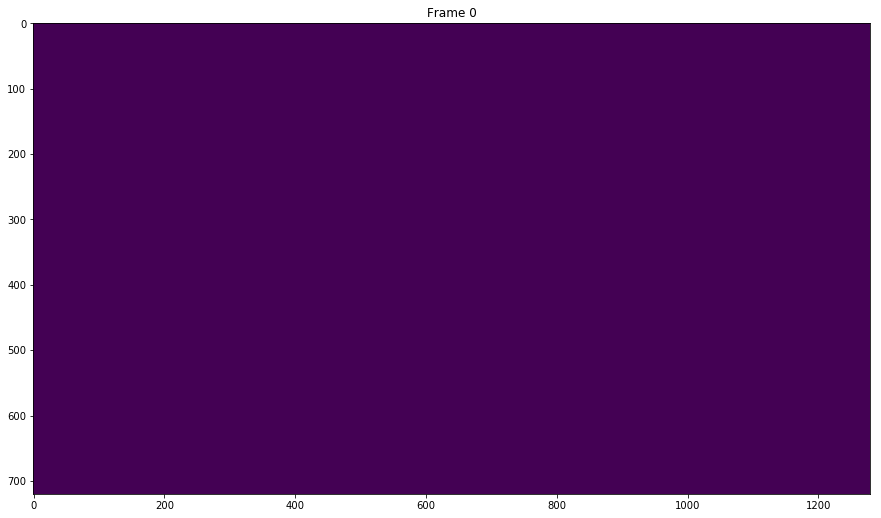

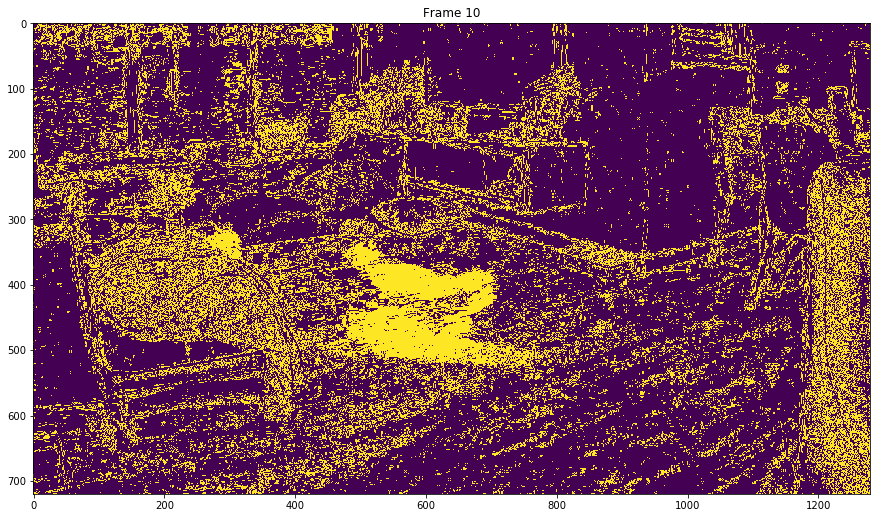

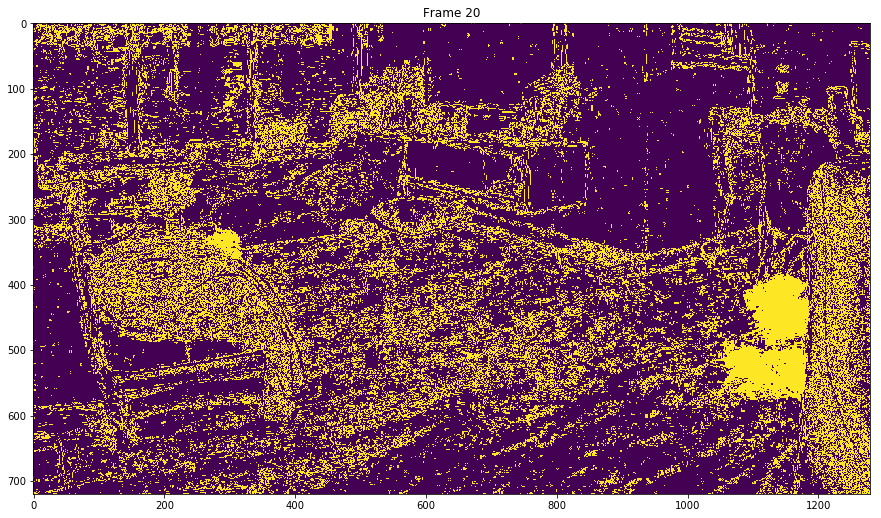

In [13]:
play_video_by_images(v_fg_mask, frame_rate=10)

### Postprocessing - Improve foreground mask

In [14]:
v_fg_mask_pp = improve_foreground(v_fg_mask)

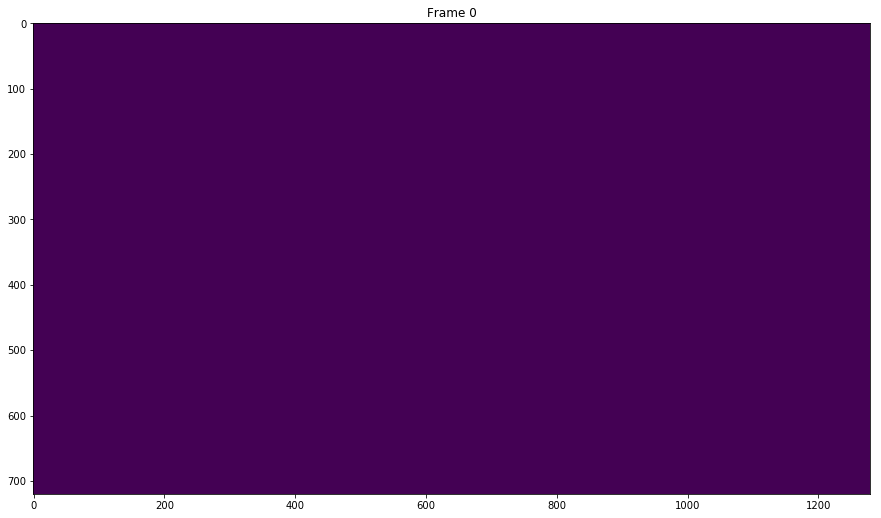

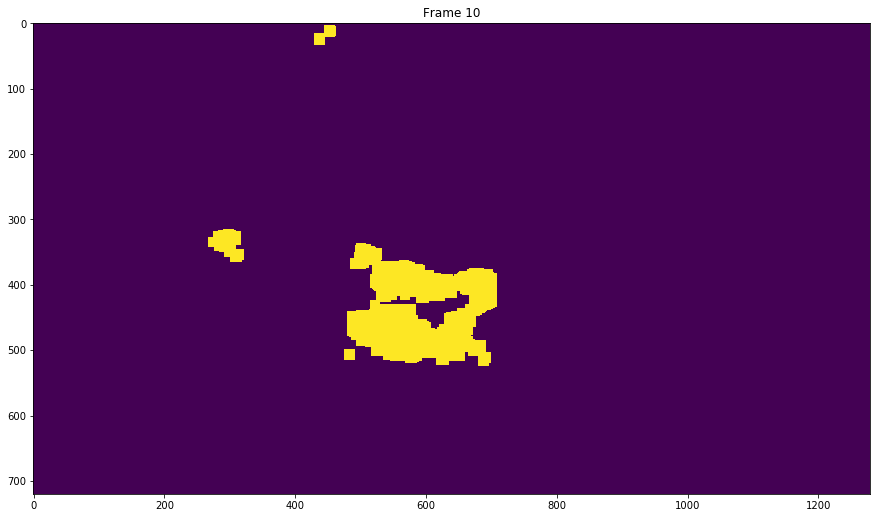

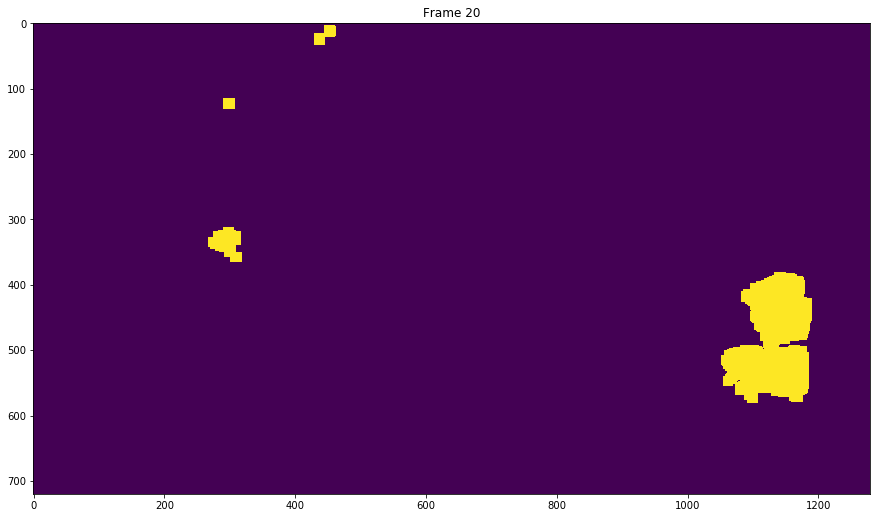

In [15]:
play_video_by_images(v_fg_mask_pp, frame_rate=10)

### Find Contours

In [16]:
frames_contours = find_contours(v_fg_mask_pp.copy())

{1: {'object1': [267, 315, 79, 66], 'object2': [430, 3, 33, 36]},
 2: {'object1': [267, 315, 106, 72], 'object2': [430, 3, 33, 36]},
 3: {'object1': [267, 314, 189, 169], 'object2': [430, 3, 33, 36]},
 4: {'object1': [267, 315, 238, 176], 'object2': [430, 3, 33, 36]},
 5: {'object1': [321, 349, 204, 144], 'object2': [266, 315, 55, 43]},
 6: {'object1': [352, 351, 195, 146], 'object2': [266, 315, 54, 43]},
 7: {'object1': [349, 341, 265, 168], 'object2': [267, 315, 53, 44]},
 8: {'object1': [362, 348, 317, 167], 'object2': [267, 315, 56, 51]},
 9: {'object1': [396, 355, 273, 163], 'object2': [267, 315, 56, 51]},
 10: {'object1': [480, 336, 230, 189], 'object2': [267, 315, 56, 51]},
 11: {'object1': [546, 425, 215, 108], 'object2': [522, 323, 237, 131]},
 12: {'object1': [573, 345, 265, 196], 'object2': [267, 312, 53, 54]},
 13: {'object1': [596, 386, 326, 167], 'object2': [657, 346, 70, 40]},
 14: {'object1': [677, 323, 301, 237], 'object2': [267, 312, 53, 54]},
 15: {'object1': [749, 3

# Object Classification 

In [28]:
import object_classification, utils
import importlib
importlib.reload(object_classification)
importlib.reload(utils)

<module 'utils' from 'C:\\Users\\alon2\\Google Drive\\Studies 2\\Year 1\\Semester A\\Computer Vision\\Final Project\\utils.py'>

In [56]:
approved_objects_total = 0
not_approved_objects_total = 0
for frame_index, detected_objects_location in frames_contours.items():
    frame = colored_vid[frame_index]
    num_of_objects = len(detected_objects_location)
    objects_info = get_detected_objects_info(frame, detected_objects_location, image_x_grid, image_y_grid, window_size)
    approved_objects, not_approved_objects = match_with_approved_objects(num_of_objects, objects_info, approved_objects_info)
    approved_objects_total += len(approved_objects)
    not_approved_objects_total += len(not_approved_objects)
    save_images_with_boxes(frame, frame_index, approved_objects, not_approved_objects, detected_objects_location, out_dir = path.join('data', 'object_classification'))

{'RED': [161.628, 139.925], 'GREEN': [157.97499999999997, 145.92], 'BLUE': [152.27599999999998, 154.98000000000002], 'location': [{'middle_grid': [61.5, 70.0], 'grid_size': 208, 'grid_coordinates': {'X': (array([54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
      dtype=int64),), 'Y': (array([64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76], dtype=int64),)}}, {'middle_grid': [89.5, 4.0], 'grid_size': 42, 'grid_coordinates': {'X': (array([87, 88, 89, 90, 91, 92], dtype=int64),), 'Y': (array([1, 2, 3, 4, 5, 6, 7], dtype=int64),)}}]}
{'RED': [166.1, 135.32999999999998], 'GREEN': [166.98714285714283, 144.8], 'BLUE': [156.3342857142857, 159.62], 'location': [{'middle_grid': [64.0, 70.5], 'grid_size': 294, 'grid_coordinates': {'X': (array([54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74], dtype=int64),), 'Y': (array([64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77],
      dtype=int64),)}}, {'middle_grid': [89.5, 4.0], 'gri

## Decide on Alert or Not 

In [20]:
image_folder = path.join('data', 'object_classification')
out_video_path = path.join(image_folder, 'video.mp4')
save_frames_video(image_folder, out_video_path)

In [21]:
Video(out_video_path, height=400, width=600)

# Measures 

In [64]:
univariate = True
cut_percent = 100
predict = True
model_path = path.join('data', 'models', 'True-100.pickle')
videos_dir_path = path.join('data', 'videos', 'cut videos')
videos_list = [video_name for video_name in listdir(videos_dir_path) if video_name.endswith('mp4')]

In [67]:
def calculate_frames_contours(video_name, k=3, t=0.7, alpha=2.5, learning_rate=0.5, k_warm_up=1, univariate=univariate,
                                                model_path=model_path, predict=predict):
    label_ = 0 if 'not_alarm' in video_name else 1
    print(f'Change detection start for video {video_name}')
    video_path = path.join('data', 'videos', 'cut videos', f'{video_name}')
    colored_vid = load_video(video_path=video_path, gray_scale=False)

    if univariate:
        vid = load_video(video_path=video_path, gray_scale=True)
        vid = resize(vid, percent=cut_percent, gray_scale=True)
    else:
        vid = colored_vid.copy()

    v_fg_mask = change_detection(vid, k=3, t=0.7, alpha=2.5, learning_rate=0.5, k_warm_up=1, univariate=univariate,
                                 model_path=model_path, predict=predict)
    v_fg_mask_pp = improve_foreground(v_fg_mask)
    return find_contours(v_fg_mask_pp), colored_vid

In [68]:
tp = []
tn = []
fp = []
fn = []
for video_name in videos_list:
    frames_contours, colored_vid = calculate_frames_contours(video_name, k=3, t=0.7, alpha=2.5, learning_rate=0.5, k_warm_up=1, univariate=univariate,
                                                model_path=model_path, predict=predict)
    approved_objects_total = 0
    not_approved_objects_total = 0
    for frame_index, detected_objects_location in frames_contours.items():
        frame = colored_vid[frame_index]
        num_of_objects = len(detected_objects_location)
        objects_info = get_detected_objects_info(frame, detected_objects_location, image_x_grid, image_y_grid, window_size)
        approved_objects, not_approved_objects = match_with_approved_objects_2(num_of_objects, objects_info, approved_objects_info)
        approved_objects_total += len(approved_objects)
        not_approved_objects_total += len(not_approved_objects)

    print(approved_objects_total, not_approved_objects_total)
    prediction_ = 0 if approved_objects_total / (approved_objects_total+not_approved_objects_total) > 0.4 else 1

    if prediction_ == 1: print(f"{video_name} contains moving unauthorized objects")
    if prediction_ == 0: print(f"{video_name} contains moving authorized objects")

    if (label_ == 1) and (prediction_ == 1):
        tn.append(video_name)
    elif (label_ == 0) and (prediction_ == 0):
        tp.append(video_name)
    elif (label_ == 0) and (prediction_ == 1):
        fp.append(video_name)
    elif (label_ == 1) and (prediction_ == 0):
        fn.append(video_name)

    print(f'Change detection done for video {video_name}')

print(f'TP: {len(tp)}')
print(f'TN: {len(tn)}')
print(f'FN: {len(fn)}')
print(f'FP: {len(fp)}')

accuracy = (len(tp) + len(tn)) / len(videos_list)
recall = len(tp) / (len(tp) + len(fn))
precision = len(tp) / (len(tp) + len(fp))

Change detection start for video alarm1.mp4


  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

GMM Model loaded from a file
Start iterating over frames to detect foreground


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:13<00:00,  5.34s/it]


GMM Model saved to a file
11 48
alarm1.mp4 contains moving unauthorized objects
Change detection done for video alarm1.mp4
Change detection start for video alarm2.mp4


  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

GMM Model loaded from a file
Start iterating over frames to detect foreground


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [03:39<00:00,  7.09s/it]


GMM Model saved to a file
0 60
alarm2.mp4 contains moving unauthorized objects
Change detection done for video alarm2.mp4
Change detection start for video alarm3.mp4


  0%|                                                                                          | 0/201 [00:00<?, ?it/s]

GMM Model loaded from a file
Start iterating over frames to detect foreground


100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [22:51<00:00,  6.83s/it]


GMM Model saved to a file
0 400
alarm3.mp4 contains moving unauthorized objects
Change detection done for video alarm3.mp4
Change detection start for video alarm4.mp4


  0%|                                                                                          | 0/225 [00:00<?, ?it/s]

GMM Model loaded from a file
Start iterating over frames to detect foreground


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [23:36<00:00,  6.29s/it]


GMM Model saved to a file
96 448
alarm4.mp4 contains moving unauthorized objects
Change detection done for video alarm4.mp4
Change detection start for video not_alarm1.mp4


  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

GMM Model loaded from a file
Start iterating over frames to detect foreground


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:29<00:00,  5.57s/it]


GMM Model saved to a file
3 19
not_alarm1.mp4 contains moving unauthorized objects
Change detection done for video not_alarm1.mp4
Change detection start for video not_alarm2.mp4


  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

GMM Model loaded from a file
Start iterating over frames to detect foreground


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [02:06<00:00,  6.04s/it]


GMM Model saved to a file
12 16
not_alarm2.mp4 contains moving authorized objects
Change detection done for video not_alarm2.mp4
Change detection start for video not_alarm3.mp4


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

GMM Model loaded from a file
Start iterating over frames to detect foreground


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:14<00:00,  5.72s/it]


GMM Model saved to a file
5 9
not_alarm3.mp4 contains moving unauthorized objects
Change detection done for video not_alarm3.mp4
Change detection start for video not_alarm4.mp4


  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

GMM Model loaded from a file
Start iterating over frames to detect foreground


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [01:44<00:00,  5.81s/it]


GMM Model saved to a file
3 31
not_alarm4.mp4 contains moving unauthorized objects
Change detection done for video not_alarm4.mp4
TP: 1
TN: 0
FN: 7
FP: 0


In [69]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

Precision: 1.0
Recall: 0.125
Accuracy: 0.125


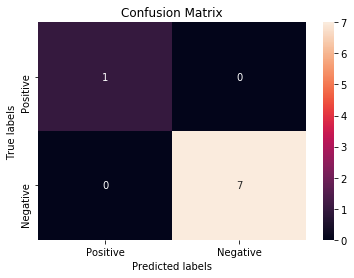

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = np.array([[len(tp), len(tn)],[len(fp), len(fn)]])

ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Positive', 'Negative']); ax.yaxis.set_ticklabels(['Positive', 'Negative']);